# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output

from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Загрузка данных

In [2]:
MODEL_SAVE_PATH = './models/'
MODEL_NAME = 'cifar10_conv'
CLASS_NAEMS = ['airplane',
               'car',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
X_train = train_images / 255.0
X_test = test_images / 255.0

y_train = to_categorical(train_labels, len(CLASS_NAEMS))
y_test = to_categorical(test_labels, len(CLASS_NAEMS))
print(train_images.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 10)


In [4]:
def show_img(images, labels, pred_labels=None):
    plt.figure(figsize=(10,2))
    images_count = min(images.shape[0], 5)
    for i in range(images_count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        label = CLASS_NAEMS[labels[i].argmax()]
        if pred_labels is not None:
            label = f'{CLASS_NAEMS[pred_labels[i].argmax()]} (real: {label})'
        
        plt.xlabel(label)
        plt.grid(False)
    
    plt.show()

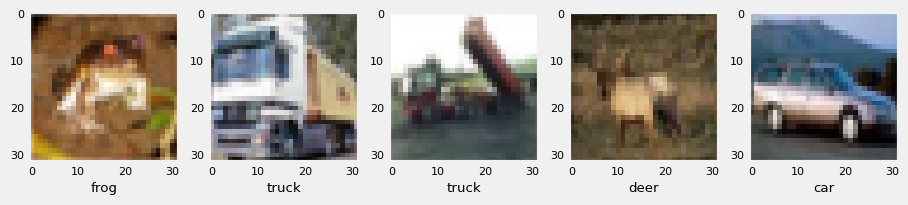

In [5]:
show_img(train_images, y_train)

## Разработка модели

### Опишем основные блоки модели 

In [6]:
def conv_layer(filters,
               conv_shape=(3, 3),
               activation='relu',
               padding='same',
               pool_shape=(2,2),
               dropout=0.2):

    layer = Sequential()

    layer.add(Conv2D(filters, conv_shape, padding=padding))
    if activation:
        layer.add(Activation(activation))
    
    layer.add(MaxPooling2D(pool_size=pool_shape))
    if dropout:
        layer.add(Dropout(dropout))

    return layer

In [7]:
def classifier_layer(layers=None, classes=10):
    if layers is None:
        layers=[128, 64, 32]

    layer = Sequential(name='Classifier')
    layer.add(Flatten())
    for layer_shape in layers:
        layer.add(Dense(layer_shape, activation="relu"))

    layer.add(Dense(classes, activation="softmax"))
    return layer

### Посмотрим как влияют сверточные слои на работу модели

In [8]:
model_params_dict = {
    'first_layer_filter_count': [4, 8, 16],
    'conv_layer_count': [1, 2, 3],
}

model_params = None
for key, value in model_params_dict.items():
    if model_params is None:
        model_params = pd.DataFrame({key: value})
    else:
        model_params = model_params.merge(pd.DataFrame({key: value}), how='cross')

model_params

,first_layer_filter_count,conv_layer_count
0,4,1
1,4,2
2,4,3
3,8,1
4,8,2
5,8,3
6,16,1
7,16,2
8,16,3


In [9]:
%%time

epochs = 5
batch_size = 32

loss = 'categorical_crossentropy'
optimizer = RMSprop(learning_rate=1e-4)
metrics=['accuracy',]

results = {
    'model': [],
    'train_loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': [],
}

for _, params in tqdm(model_params.iterrows(), total=model_params.shape[0]):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))

    conv_layers = []
    filter_count = params['first_layer_filter_count']
    for _ in range(params['conv_layer_count']):
        model.add(conv_layer(filter_count))
        conv_layers.append(str(filter_count))
        filter_count *= 2

    model.add(classifier_layer())
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test), 
                        verbose=0)

    results['model'].append(', '.join(conv_layers))
    results['train_loss'].append(history.history['loss'][-1])
    results['val_loss'].append(history.history['val_loss'][-1])
    results['accuracy'].append(history.history['accuracy'][-1])
    results['val_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 10min 22s
Wall time: 8min 2s


In [10]:
results = pd.DataFrame(results)
results.sort_values('val_accuracy', ascending=False)

,model,train_loss,val_loss,accuracy,val_accuracy
6,16,1.293340,1.267850,0.54102,0.5495
7,"16, 32",1.400513,1.344808,0.49936,0.5216
3,8,1.392314,1.354435,0.50356,0.5151
4,"8, 16",1.488769,1.430369,0.46600,0.4933
8,"16, 32, 64",1.506115,1.469363,0.45346,0.4727
0,4,1.577561,1.525781,0.43932,0.4571
5,"8, 16, 32",1.586926,1.542137,0.42396,0.4484
1,"4, 8",1.653130,1.656134,0.40490,0.4094
2,"4, 8, 16",1.738785,1.739353,0.36138,0.3669


Чем ментьше количество слоев и их размер там бысрее модель учится, но в определенный момент, она начинает проигрывать тем, у которых больше обучаемых параметров. Сеть со слишком большим количеством обучаемых параметров начинает быстрее переобучаться.

## Обучим финальную модель 

In [11]:
class OnEpochEnd(Callback):
    def __init__(self):
        super().__init__()
        self.best_acc = 0
        self.best_epoch = 0
        self.save_path = MODEL_SAVE_PATH + MODEL_NAME + '_best.h5'

    def on_epoch_end(self, epoch, logs=None):
        if self.best_acc < logs['val_accuracy']:
            self.best_acc = logs['val_accuracy']
            self.best_epoch = epoch
            self.model.save(self.save_path)

        clear_output(wait=True)
        print(f'Epoch {self.best_epoch+1}:')
        print(f'\tModel with best accuracy saved to {self.save_path}')
        print(f'\tval_accuracy: {self.best_acc}\n')

        test_imgs = np.random.randint(0, X_test.shape[0], size=5)
        pred = self.model.predict(X_test[test_imgs])
        show_img(X_test[test_imgs], y_test[test_imgs], pred)

Epoch 27:
	Model with best accuracy saved to ./models/cifar10_conv_best.h5
	val_accuracy: 0.7221999764442444

1/1 [==============================] - 0s 11ms/step


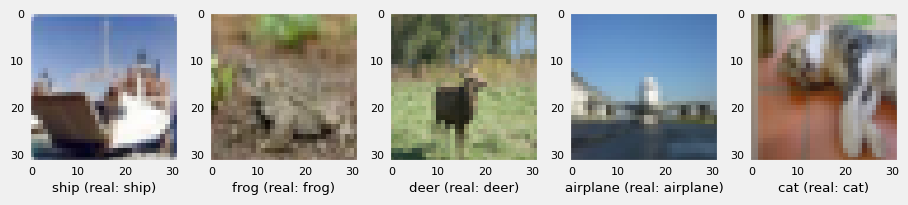

1563/1563 [==============================] - 7s 4ms/step - loss: 0.4140 - accuracy: 0.8541 - val_loss: 0.9508 - val_accuracy: 0.7134


In [12]:
epochs = 50
batch_size = 32

loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics=['accuracy',]
callback = OnEpochEnd()

model = Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(conv_layer(16))
model.add(conv_layer(32))
model.add(classifier_layer())
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[callback,])

In [13]:
def plot_history(history):
    plt.figure(figsize=(14, 8))

    for i, key in enumerate(['loss', 'accuracy']):
        plt.subplot(1, 2, i+1)
        plt.plot(history[key], label=key)
        plt.plot(history['val_'+key], label='val_'+key)
        plt.title(key)
        plt.grid(True)
        plt.legend()

    plt.show()

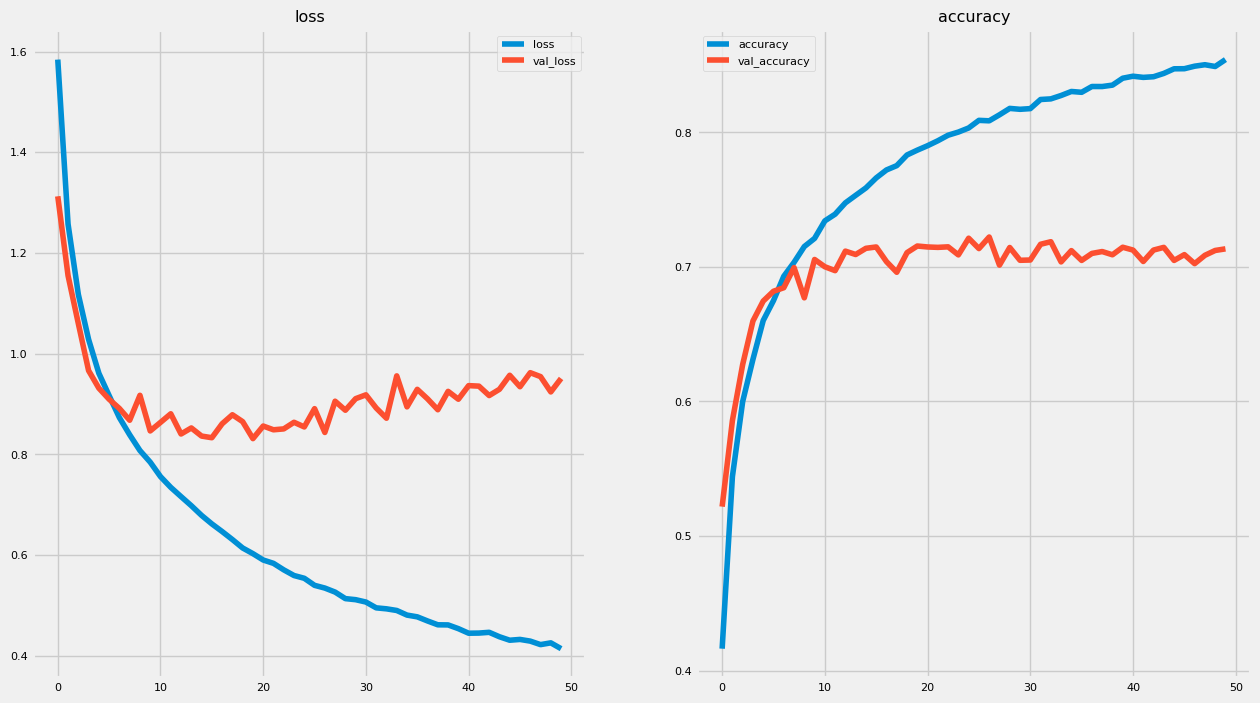

In [14]:
plot_history(history.history)

1/1 [==============================] - 0s 36ms/step


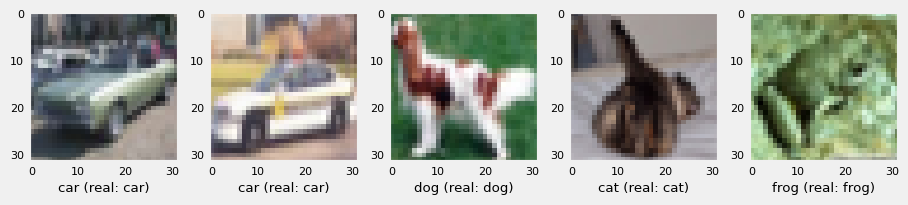

In [15]:
best_model = load_model(callback.save_path)
test_imgs = np.random.randint(0, X_test.shape[0], size=5)
pred = best_model.predict(X_test[test_imgs])
show_img(X_test[test_imgs], y_test[test_imgs], pred)

В районе 10-й эпохи модель начала переобучаться